In [1]:
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot, row, column
import pandas as pd

In [2]:
df = pd.read_csv('data/pyramid_data.csv')

In [3]:
data = (df.groupby(['Age_Bands', 'Area', 'Gender'])['Population']
        .sum()
        .reset_index(name='Population'))

In [4]:
y_text = (df['Age_Bands'].unique())

In [5]:
output_notebook()

Loading BokehJS ...

In [6]:
def pop_pyramid(dataframe, facet_col, facet_value):
    """
    Create a population pyramid plot for each facet value
    """   
    df = dataframe[dataframe[facet_col]==facet_value].copy()
    
    offset = 0.015
    total_male = df[df['Gender'] == 'Male']['Population'].sum()
    total_female = df[df['Gender'] == 'Female']['Population'].sum()
    
    x_male = ([(-x/total_male) - offset for x in df[df['Gender'] == 'Male']
               .Population
               .values])
    x_female = ([(x/total_female) + offset for x in df[df['Gender'] == 'Female']
                 .Population
                 .values])

    p = figure(plot_width=600, plot_height=400, x_range=(-0.15, 0.15), y_range=(0, 20))

    male_bar = p.hbar(y=range(1,20), height=0.5, right=x_male, color="#bebada", left=-offset,
                      line_dash='solid', line_color='black', line_width=0.5)
    female_bar = p.hbar(y=range(1,20), height=0.5, right=x_female, color="#8dd3c7", left=offset,
                     line_dash='solid', line_color='black', line_width=0.5)
    text = p.text(x=[0]*19, y=range(1,20), text=y_text,
                  text_align='center', y_offset=8, text_font_size="11px")

    #Set formatting options
    p.grid.visible = False
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.outline_line_color = 'darkgrey'
    p.toolbar.logo = None
    p.toolbar_location = None
    
    #Set title options
    p.title.text = facet_value
    p.title.align = 'center'
    #if exporting individual images for comparison, remove titles first
    #bokeh.io.export_png(p,filename='images/pp_{}.png'.format(facet_value))
    return p

In [7]:
plots = []
for ca in data['Area'].unique():
    plots.append(pop_pyramid(data,'Area',ca))

In [8]:
plot_grid = gridplot(plots,ncols=5)
bokeh.io.export_png(plot_grid, filename='images/all_ca.png')

C:\Users\germap01\AppData\Local\Continuum\anaconda3\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


'C:\\Users\\germap01\\Python\\GIT PROJECTS\\population-sim\\workspace\\Bokeh\\images\\all_ca.png'

#### Compare images of population pyramids for similar shapes

In [9]:
%matplotlib inline

In [12]:
from imageio import imread
from scipy.linalg import norm
from scipy import sum, average
from pathlib import Path
import os

In [13]:
fp = Path.cwd()

In [24]:
#code adapted from:
#https://stackoverflow.com/questions/189943/
#how-can-i-quantify-difference-between-two-images#3935002
def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return average(arr, -1)
    else:
        return arr

def compare_images(img1, img2):
    # calculate the difference and its norms
    diff = img1 - img2
    m_norm = sum(abs(diff)) # Manhattan norm
    z_norm = norm(diff.ravel(), 0) # Zero norm
    return (m_norm, z_norm)

def main(file1, file2):
    # read images as 2D arrays (convert to grayscale for simplicity)
    img1 = to_grayscale(imread(file1).astype(float))
    img2 = to_grayscale(imread(file2).astype(float))
    # compare
    n_m, n_0 = compare_images(img1, img2)
    return n_m    
    #print ("Manhattan norm:", n_m, "/ per pixel:", n_m/img1.size)
    #print ("Zero norm:", n_0, "/ per pixel:", n_0*1.0/img1.size)

In [16]:
ref_image = 'images/pp_Uist.png'
comp_images = ['images/compare/' + x for x in os.listdir(fp / 'images/compare')]

In [22]:
image_dict = {}
#extract area name from filename and pair it with the output of the compare function
for image in comp_images:
    image_dict[image[18:-4]] = main(ref_image, image)

sorted_dict = sorted(image_dict, key=lambda x : image_dict[x])

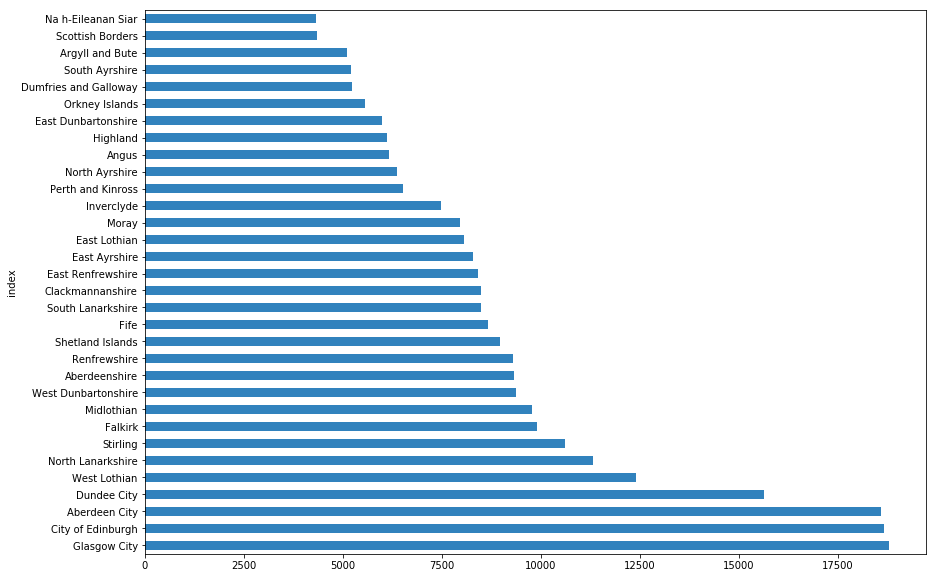

In [23]:
#visualise the differences from Uist for each council area
like_df = (pd.DataFrame.from_dict(image_dict, orient='index', columns=['Value'])
            .reset_index()
            .sort_values('Value', ascending=False))

like_df.plot(x='index', y='Value', kind='barh', legend=False, figsize=(14,10), colormap='tab20c')